# Basic Classification Machine Learning Example

For this we will grab a synthetic data set and then a toy dataset to perform some classification. Then we will perform it with an unbalanced dataset as well 

## Load Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.datasets import make_classification

In [3]:
X, y = make_classification(n_samples=50000, n_features=15, n_informative=5, n_redundant=3, n_repeated=2, random_state=101)

In [4]:
df = pd.DataFrame(X)
df['target'] = y

After creating our dataset we will plot a couple of projections to have an idea if we need to tweak our data

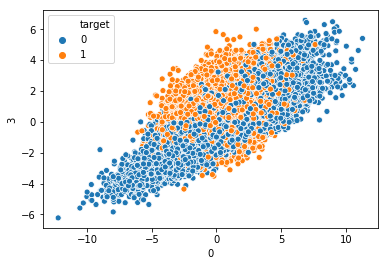

In [5]:
sns.scatterplot(data=df, x=0, y=3, hue='target')

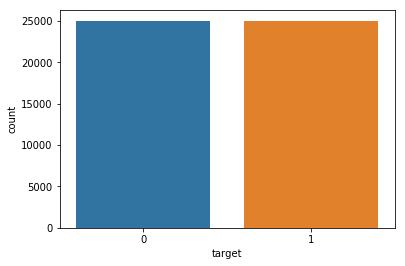

In [6]:
sns.countplot(df['target'])

We have a balanced synthetic dataset. This means there are no nulls, not outliers and no imbalance in the target variable. We need to find if we have redundant or irrelevant features

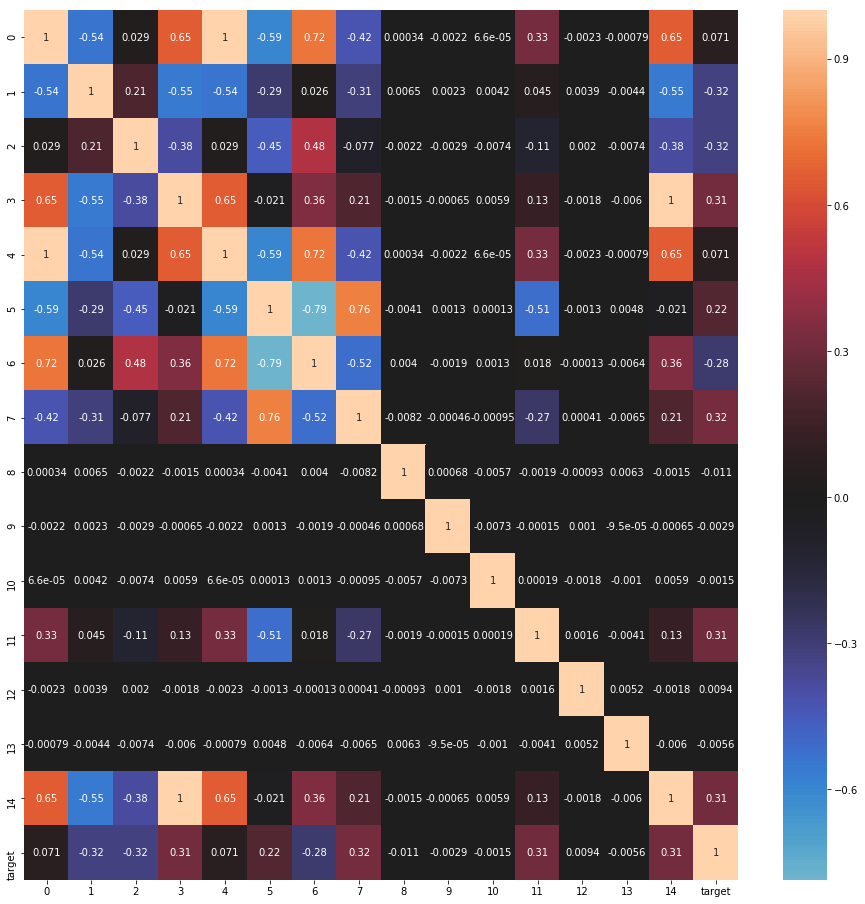

In [7]:
plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, center=0)

we can see that features 4, 0  are a repeated class as they have a 1 correlation, same thing happens with 14 and 3. we can see their correlations against the target variable are also the same. So we can drop those 2 variables right away. 

In [8]:
df.drop([0, 3], axis=1, inplace=True)

We can also see a lot of features that are not correlated with the target variable. We could try to remove these. but an algorithm like Random Forest will be able to auto select the most important features

### Modelling

### Data Prep

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [10]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

We start from the simplest model and we increase complexity as we go ahead

As the data is perfectly balanced (as all things should be), we can use the accuracy as a metric to evaluate our models

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
log_model = LogisticRegression(solver='lbfgs')
cross_val_score(log_model, X_train, y_train, cv=5)

array([0.78580158, 0.79055556, 0.79188889, 0.788     , 0.79475497])

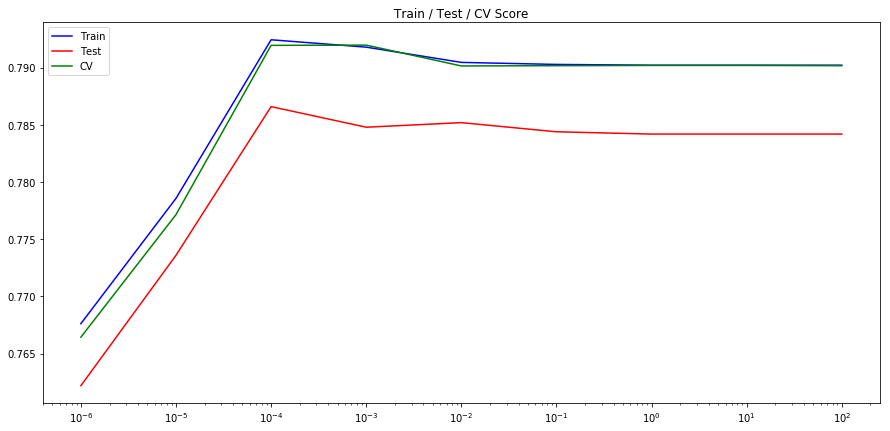

In [13]:
params = np.logspace(-6,2,9)
train_score = []
test_score = []
cv_score = []

for param in params:
    model = LogisticRegression(C=param, solver='lbfgs')
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
    cv_score.append(cross_val_score(model, X_train, y_train, cv=5).mean())

plt.subplots(figsize=(15,7))
plt.plot(params, train_score, color='blue', label='Train')
plt.plot(params, test_score, color='red', label='Test')
plt.plot(params, cv_score, color='green', label='CV')
plt.xscale('log')
plt.title("Train / Test / CV Score")
plt.legend()

Seems like 0.0001 is the best scores we have. We will now zoom in and re run this to get a better score

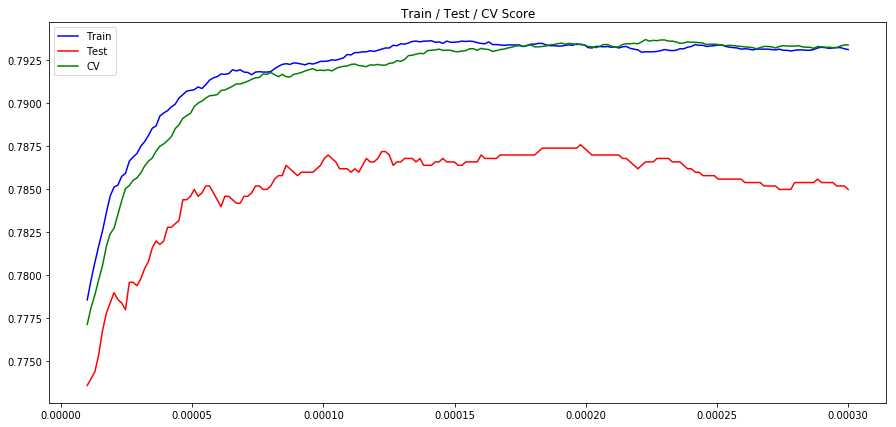

In [20]:
params = np.linspace(0.00001,0.0003,200)
train_score = []
test_score = []
cv_score = []

for param in params:
    model = LogisticRegression(C=param, solver='lbfgs')
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
    cv_score.append(cross_val_score(model, X_train, y_train, cv=5).mean())

plt.subplots(figsize=(15,7))
plt.plot(params, train_score, color='blue', label='Train')
plt.plot(params, test_score, color='red', label='Test')
plt.plot(params, cv_score, color='green', label='CV')
#plt.xscale('log')
plt.title("Train / Test / CV Score")
plt.legend()

0.00017 seems to be the best score overall.

In [21]:
best_lr_model = LogisticRegression(C=0.00017, solver='lbfgs')

In [22]:
best_lr_model.fit(X_train, y_train)

LogisticRegression(C=0.00017, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [23]:
print("Train Score: ", best_lr_model.score(X_train, y_train))
print("Test Score: ", best_lr_model.score(X_test, y_test))

Train Score:  0.7934
Test Score:  0.787


Now we get a confusion Matrix and classification report

In [25]:
print(confusion_matrix(y_test, best_lr_model.predict(X_test)))

[[1945  526]
 [ 539 1990]]


In [26]:
print(classification_report(y_test, best_lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2471
           1       0.79      0.79      0.79      2529

   micro avg       0.79      0.79      0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



We can see our results from a simple logistic regression. This is good because it provides us with a simple baseline. In case that other models don't perform better, Logistic Regression is easy to train and easy to implement. 

### K-Nearest Neighbors

Another simple algorithm for classification is KNN which is a distance based classifier. It's is extremely fast to train (basically no training required) and very simple to explain and tweak if needed.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

The parameters we want to play with for KNN are the neighbors it chooses. The voting mechanism and the distance that it calculates on. We will try with default parameters and iterating through neighbors. And then do a Grid Search with the other parameters.

In [29]:
base_knn_model = KNeighborsClassifier()

In [30]:
cross_val_score(base_knn_model, X_train, y_train, cv=5)

array([0.90567715, 0.91322222, 0.91311111, 0.90444444, 0.91232359])

It seems we get a really nice improvement over logistic regression. We will try hyperparameter tuning now

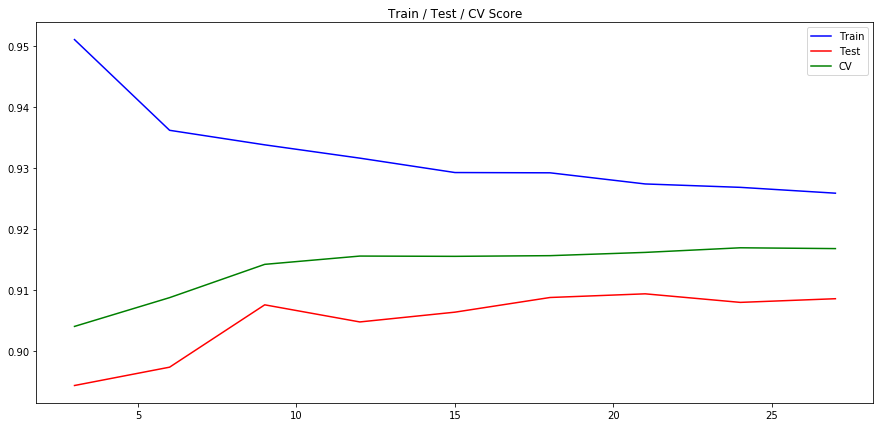

In [32]:
neighbors = np.arange(3,30,3)
train_score = []
test_score = []
cv_score = []

for neighbor in neighbors:
    model = KNeighborsClassifier(n_neighbors=neighbor)
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
    cv_score.append(cross_val_score(model, X_train, y_train, cv=5).mean())

plt.subplots(figsize=(15,7))
plt.plot(neighbors, train_score, color='blue', label='Train')
plt.plot(neighbors, test_score, color='red', label='Test')
plt.plot(neighbors, cv_score, color='green', label='CV')
plt.title("Train / Test / CV Score")
plt.legend()

Seems like 20 neighbors is like the best 